In [4]:
import os
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
from glob import glob
import numpy as np
import matplotlib
import seaborn as sns
import PIL
PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import sys
import json
import pandas as pd
import cvlib as cv
from cvlib.object_detection import draw_bbox
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import tensorflow_datasets as tfds

In [5]:
import pathlib

In [11]:
dataset_path = 'C:/Users/82106/Documents/ds_study/source_code/DL project/001_G1'

In [12]:
batch_size = 32
img_height = 180
img_width = 180

In [37]:
train_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 486 files belonging to 4 classes.
Using 389 files for training.


In [14]:
val_x = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height,img_width),
    batch_size=batch_size
)

Found 486 files belonging to 4 classes.
Using 97 files for validation.


In [15]:
class_names = train_x.class_names
print(class_names)

['normal', 'phone', 'sleep', 'yawn']


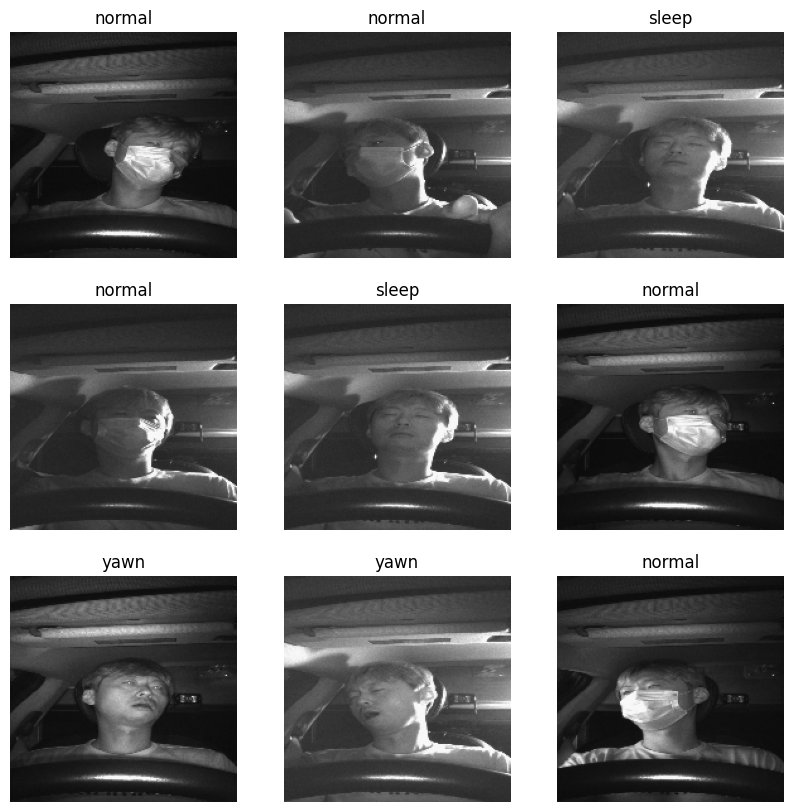

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_x.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_x:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
normalized_x = train_x.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_x))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.022452196 0.9887196


## vggnet 사용

In [49]:
num_classes = 4

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax'),
  tf.keras.layers.Dense(num_classes)
])

In [53]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [51]:
hist = model.fit(
  train_x,
  validation_data=val_x,
  epochs=3
)

Epoch 1/3
13/13 [==============================] - 16s 1s/step - loss: 1.3206 - accuracy: 0.4165 - val_loss: 1.2953 - val_accuracy: 0.4021
Epoch 2/3
13/13 [==============================] - 16s 1s/step - loss: 1.2802 - accuracy: 0.4396 - val_loss: 1.3021 - val_accuracy: 0.4021
Epoch 3/3
13/13 [==============================] - 16s 1s/step - loss: 1.2927 - accuracy: 0.4396 - val_loss: 1.3010 - val_accuracy: 0.4021


In [ ]:
#### 검증 정확도가 훈련 정확도에 비해 낮으면 모델이 과대적합되었음을 알 수 있다.

In [23]:
hist.history

{'loss': [1.3497352600097656, 1.3217616081237793, 1.3165849447250366],
 'accuracy': [0.39074549078941345, 0.4395886957645416, 0.4395886957645416],
 'val_loss': [1.3320460319519043, 1.3279237747192383, 1.3240886926651],
 'val_accuracy': [0.4020618498325348, 0.4020618498325348, 0.4020618498325348]}

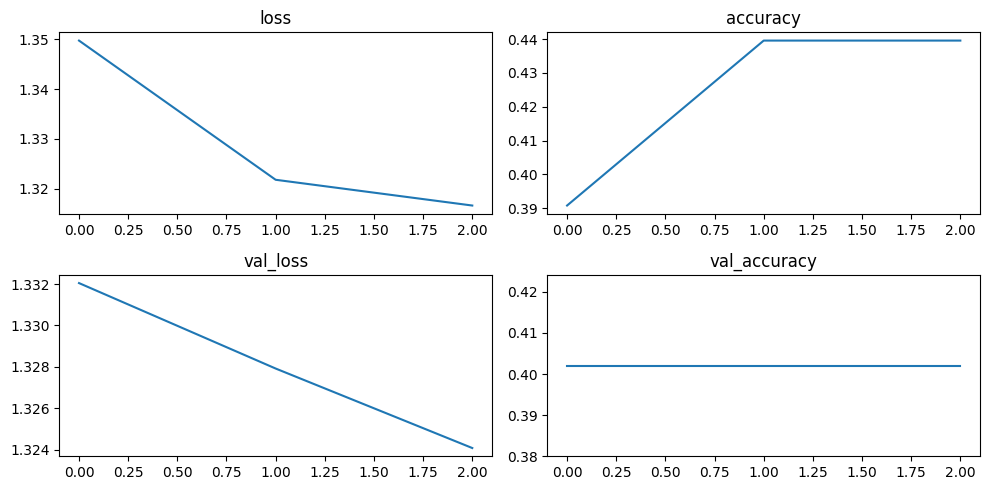

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

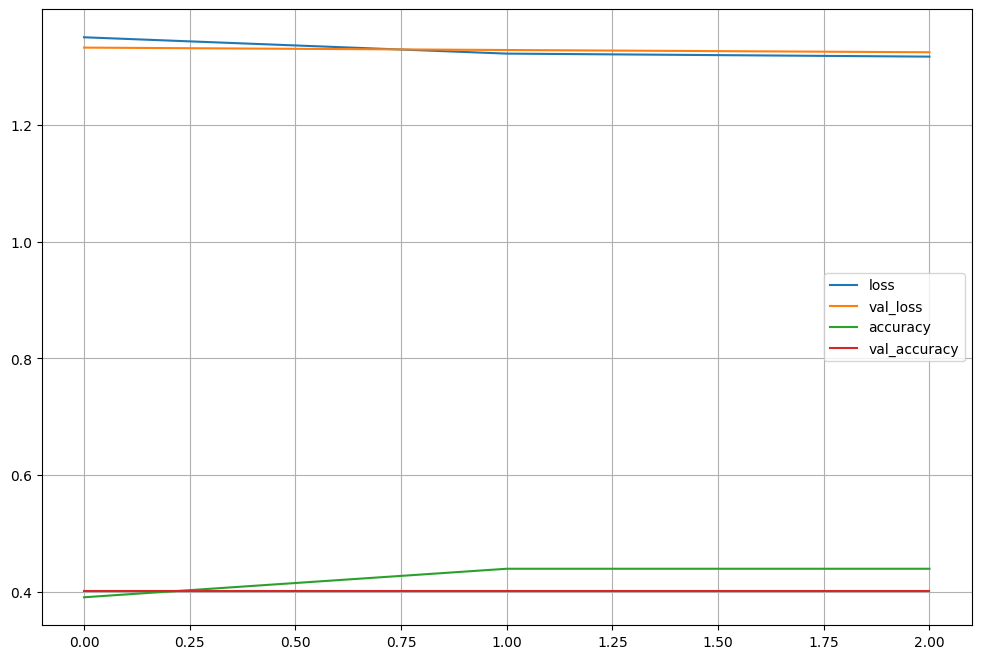

In [41]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12,8))

for each in plot_target:
    plt.plot(hist.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [42]:
score = model.evaluate(train_x)
score

13/13 [==============================] - 6s 244ms/step - loss: 1.3139 - accuracy: 0.4396


[1.3138647079467773, 0.4395886957645416]

## resnet 사용

In [1]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Add

In [2]:
def build_resnet(input_shape):
    inputs = Input(input_shape)

    net = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    net = MaxPool2D()(net)

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net1_1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net = Add()([net1_1, net3])

    net1 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net)
    net2 = Conv2D(64, kernel_size=3, padding='same', activation='relu')(net1)
    net3 = Conv2D(64, kernel_size=1, padding='same', activation='relu')(net2)

    net = Add()([net, net3])

    net = MaxPool2D()(net)

    net = Flatten()(net)
    net = Dense(10, activation='softmax')(net)

    model2 = tf.keras.Model(inputs=inputs, outputs=net)

    return model2

In [26]:
model2 = build_resnet((180,180,3))

In [27]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 90, 90, 32)   896         ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 45, 45, 32)  0           ['conv2d_19[0][0]']              
                                                                                                  
 conv2d_20 (Conv2D)             (None, 45, 45, 64)   2112        ['max_pooling2d_7[0][0]']  

In [28]:
model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [29]:
hist2 = model2.fit(
  train_x,
  validation_data=val_x,
  epochs=3)

Epoch 1/3
13/13 [==============================] - 13s 853ms/step - loss: 90.5841 - accuracy: 0.2982 - val_loss: 48.2702 - val_accuracy: 0.3402
Epoch 2/3
13/13 [==============================] - 12s 875ms/step - loss: 21.7248 - accuracy: 0.3548 - val_loss: 16.6969 - val_accuracy: 0.4227
Epoch 3/3
13/13 [==============================] - 13s 971ms/step - loss: 6.1449 - accuracy: 0.4396 - val_loss: 3.9817 - val_accuracy: 0.3918


In [31]:
hist2.history

{'loss': [90.58406066894531, 21.724821090698242, 6.144860744476318],
 'accuracy': [0.2982005178928375, 0.35475578904151917, 0.4395886957645416],
 'val_loss': [48.27020263671875, 16.696943283081055, 3.981708526611328],
 'val_accuracy': [0.34020617604255676,
  0.42268040776252747,
  0.39175257086753845]}

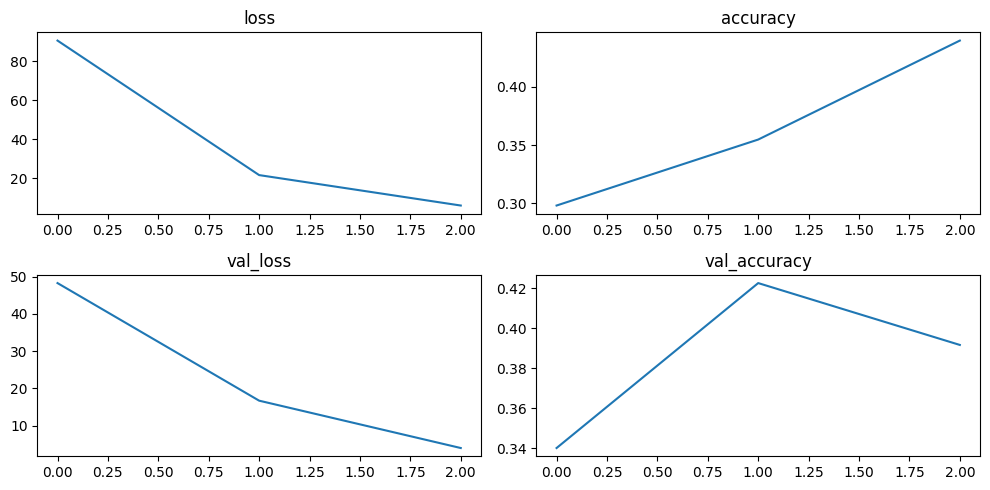

In [33]:
plt.figure(figsize=(10,5))
plt.subplot(221)
plt.plot(hist2.history['loss'])
plt.title('loss')
plt.subplot(222)
plt.plot(hist2.history['accuracy'])
plt.title('accuracy')
plt.subplot(223)
plt.plot(hist2.history['val_loss'])
plt.title('val_loss')
plt.subplot(224)
plt.plot(hist2.history['val_accuracy'])
plt.title('val_accuracy')

plt.tight_layout()
plt.show()

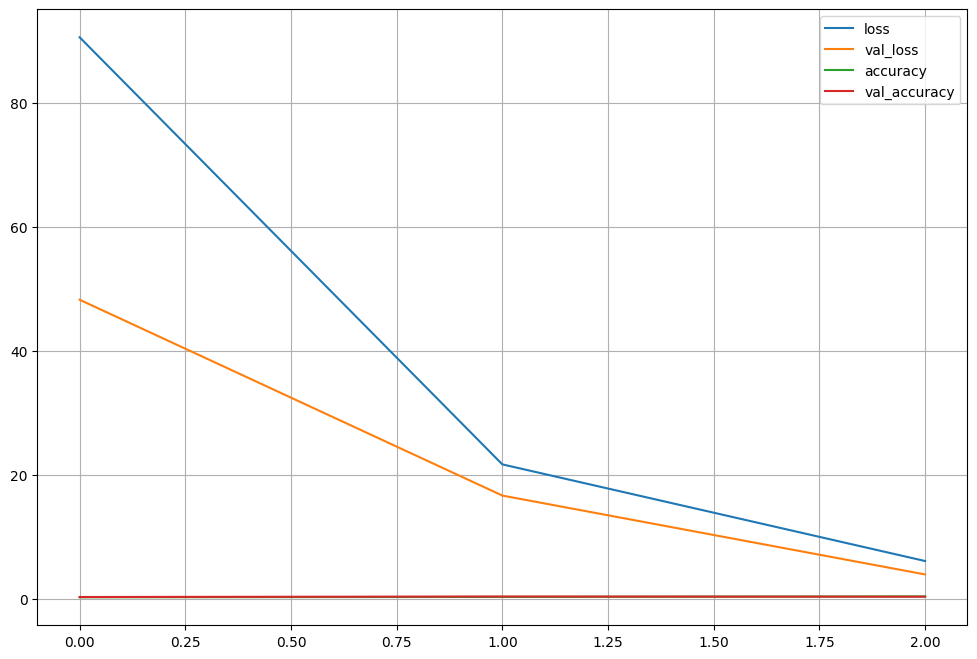

In [40]:
plot_target = ['loss', 'val_loss', 'accuracy', 'val_accuracy']

plt.figure(figsize=(12,8))

for each in plot_target:
    plt.plot(hist2.history[each], label=each)

plt.legend()
plt.grid()
plt.show()

In [38]:
score2 = model2.evaluate(val_x)
score2

4/4 [==============================] - 2s 211ms/step - loss: 3.9817 - accuracy: 0.3918


[3.9817090034484863, 0.39175257086753845]